In [ ]:
#|default_exp forecast

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

# MLForecast

> Full pipeline encapsulation

In [ ]:
#|export
import copy
import warnings
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, clone

from mlforecast.core import (
    DateFeature,
    Differences,
    Freq,
    LagTransforms,
    Lags,
    Models,
    TimeSeries,
    _name_models,
)
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.utils import backtest_splits

In [ ]:
#|hide
from fastcore.test import test_warns, test_eq
from nbdev import show_doc
from sklearn import set_config

In [ ]:
#|hide
set_config(display='text')
warnings.simplefilter('ignore', UserWarning)

In [ ]:
#|export
class MLForecast:
    def __init__(
        self,
        models: Models,
        freq: Optional[Freq] = None,
        lags: Optional[Lags] = None,
        lag_transforms: Optional[LagTransforms] = None,
        date_features: Optional[Iterable[DateFeature]] = None,
        differences: Optional[Differences] = None,
        num_threads: int = 1,
    ):
        """Create forecast object

        Parameters
        ----------
        models : regressor or list of regressors
            Models that will be trained and used to compute the forecasts.
        freq : str or int or pd.offsets.BaseOffset, optional (default=None)
            Pandas offset, pandas offset alias, e.g. 'D', 'W-THU' or integer denoting the frequency of the series.
        lags : list of int, optional (default=None)
            Lags of the target to use as features.
        lag_transforms : dict of int to list of functions, optional (default=None)
            Mapping of target lags to their transformations.
        date_features : list of str or callable, optional (default=None)
            Features computed from the dates. Can be pandas date attributes or functions that will take the dates as input.
        differences : list of int, optional (default=None)
            Differences to take of the target before computing the features. These are restored at the forecasting step.
        num_threads : int (default=1)
            Number of threads to use when computing the features.
        """
        if not isinstance(models, dict) and not isinstance(models, list):
            models = [models]
        if isinstance(models, list):
            model_names = _name_models([m.__class__.__name__ for m in models])            
            models_with_names = dict(zip(model_names, models))
        else:
            models_with_names = models
        self.models = models_with_names
        self.ts = TimeSeries(freq, lags, lag_transforms, date_features, differences, num_threads)
        
    def __repr__(self):
        return (
            f'{self.__class__.__name__}(models=[{", ".join(self.models.keys())}], '
            f'freq={self.freq}, '
            f'lag_features={list(self.ts.transforms.keys())}, '
            f'date_features={self.ts.date_features}, '
            f'num_threads={self.ts.num_threads})'
        )
    
    @property
    def freq(self):
        return self.ts.freq
    
    @classmethod
    def from_cv(cls, cv: LightGBMCV) -> 'MLForecast':
        if not hasattr(cv, 'best_iteration_'):
            raise ValueError('LightGBMCV object must be fitted first.')
        import lightgbm as lgb
        fcst = cls(lgb.LGBMRegressor(**{**cv.params, 'n_estimators': cv.best_iteration_}))
        fcst.ts = copy.deepcopy(cv.ts)
        return fcst

    def preprocess(
        self,
        data: pd.DataFrame,
        id_col: str,
        time_col: str,
        target_col: str,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
        max_horizon: Optional[int] = None,
        return_X_y: bool = False,
    ) -> Union[pd.DataFrame, Tuple[pd.DataFrame, Union[pd.Series, pd.DataFrame]]]:
        """Add the features to `data`.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.
        max_horizon: int, optional (default=None)
            Train this many models, where each model will predict a specific horizon.
        return_X_y: bool (default=False)
            Return a tuple with the features and the target. If False will return a single dataframe.

        Returns
        -------
        result : pandas DataFrame or tuple of pandas Dataframe and either a pandas Series or a pandas Dataframe (for multi-output regression).
            `data` plus added features and target(s).
        """
        return self.ts.fit_transform(
            data,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            static_features=static_features,
            dropna=dropna,
            keep_last_n=keep_last_n,
            max_horizon=max_horizon,
            return_X_y=return_X_y,
        )
    
    def fit_models(
        self,
        X: pd.DataFrame,
        y: Union[pd.Series, pd.DataFrame],
    ) -> 'MLForecast':
        """Manually train models. Use this if you called `Forecast.preprocess` beforehand.
        
        Parameters
        ----------
        X : pandas DataFrame
            Features.
        y : pandas Series or pandas DataFrame (multi-output).
            Target.
            
        Returns
        -------
        self : Forecast
            Forecast object with trained models.
        """
        self.models_: Dict[str, Union[BaseEstimator, List[BaseEstimator]]] = {}
        for name, model in self.models.items():
            if y.ndim == 2 and y.shape[1] > 1:
                self.models_[name] = []                
                for col in y:
                    keep = y[col].notnull()
                    self.models_[name].append(clone(model).fit(X.loc[keep], y.loc[keep, col]))
            else:
                self.models_[name] = clone(model).fit(X, y)
        return self

    def fit(
        self,
        data: pd.DataFrame,
        id_col: str,
        time_col: str,
        target_col: str,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
        max_horizon: Optional[int] = None,
    ) -> 'MLForecast':
        """Apply the feature engineering and train the models.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.
        max_horizon: int, optional (default=None)
            Train this many models, where each model will predict a specific horizon.

        Returns
        -------
        self : Forecast
            Forecast object with series values and trained models.
        """
        X, y = self.preprocess(
            data,
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            static_features=static_features,
            dropna=dropna,
            keep_last_n=keep_last_n,
            max_horizon=max_horizon,
            return_X_y=True,
        )
        features = X.columns.drop(time_col)
        if id_col != 'index' and id_col not in self.ts.static_features:
            features = features.drop(id_col)
        X = X[features]
        return self.fit_models(X, y)

    def predict(
        self,
        horizon: int,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        before_predict_callback: Optional[Callable] = None,
        after_predict_callback: Optional[Callable] = None,
        new_data: Optional[pd.DataFrame] = None,
    ) -> pd.DataFrame:
        """Compute the predictions for the next `horizon` steps.
        
        Parameters
        ----------
        horizon : int
            Number of periods to predict.
        dynamic_dfs : list of pandas DataFrame, optional (default=None)
            Future values of the dynamic features, e.g. prices.
        before_predict_callback : callable, optional (default=None)
            Function to call on the features before computing the predictions.
                This function will take the input dataframe that will be passed to the model for predicting and should return a dataframe with the same structure.
                The series identifier is on the index.
        after_predict_callback : callable, optional (default=None)
            Function to call on the predictions before updating the targets.
                This function will take a pandas Series with the predictions and should return another one with the same structure.
                The series identifier is on the index.   
        new_data : pandas DataFrame, optional (default=None)
            Series data of new observations for which forecasts are to be generated. 
                This dataframe should have the same structure as the one used to fit the model, including any features and time series data. 
                If `new_data` is not None, the method will generate forecasts for the new observations.


        Returns
        -------
        result : pandas DataFrame
            Predictions for each serie and timestep, with one column per model.
        """
        if not hasattr(self, 'models_'):
            raise ValueError('No fitted models found. You have to call fit or preprocess + fit_models.')
            
        if new_data is not None:
            new_ts = TimeSeries(
                self.ts.freq, self.ts.lags, 
                self.ts.lag_transforms, self.ts.date_features, 
                self.ts.differences, self.ts.num_threads
            )
            new_ts._fit(
                new_data, 
                self.ts.id_col, self.ts.time_col, self.ts.target_col, 
                self.ts.static_features.columns, 
                self.ts.keep_last_n
            )
            new_ts.max_horizon = self.ts.max_horizon
            ts = new_ts
        else:
            ts = self.ts
            
        return ts.predict(
            self.models_, horizon, dynamic_dfs, before_predict_callback, after_predict_callback
        )

    def cross_validation(
        self,
        data: pd.DataFrame,
        n_windows: int,
        window_size: int,
        id_col: str,
        time_col: str,
        target_col: str,
        step_size: Optional[int] = None,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        before_predict_callback: Optional[Callable] = None,
        after_predict_callback: Optional[Callable] = None,
    ):
        """Perform time series cross validation.
        Creates `n_windows` splits where each window has `window_size` test periods, 
        trains the models, computes the predictions and merges the actuals.
        
        Parameters
        ----------
        data : pandas DataFrame
            Series data in long format.
        n_windows : int
            Number of windows to evaluate.
        window_size : int
            Number of test periods in each window.
        id_col : str
            Column that identifies each serie. If 'index' then the index is used.
        time_col : str
            Column that identifies each timestep, its values can be timestamps or integers.
        target_col : str
            Column that contains the target.
        step_size : int, optional (default=None)
            Step size between each cross validation window. If None it will be equal to `window_size`.
        static_features : list of str, optional (default=None)
            Names of the features that are static and will be repeated when forecasting.
        dropna : bool (default=True)
            Drop rows with missing values produced by the transformations.
        keep_last_n : int, optional (default=None)
            Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it.
        dynamic_dfs : list of pandas DataFrame, optional (default=None)
            Future values of the dynamic features, e.g. prices.
        before_predict_callback : callable, optional (default=None)
            Function to call on the features before computing the predictions.
                This function will take the input dataframe that will be passed to the model for predicting and should return a dataframe with the same structure.
                The series identifier is on the index.
        after_predict_callback : callable, optional (default=None)
            Function to call on the predictions before updating the targets.
                This function will take a pandas Series with the predictions and should return another one with the same structure.
                The series identifier is on the index.           

        Returns
        -------
        result : pandas DataFrame
            Predictions for each window with the series id, timestamp, last train date, target value and predictions from each model.
        """
        results = []
        self.cv_models_ = []
        if id_col != 'index':
            data = data.set_index(id_col)
        
        if np.issubdtype(data[time_col].dtype.type, np.integer):
            freq = 1
        else:
            freq = self.freq

        for train_end, train, valid in backtest_splits(data, n_windows, window_size, freq, step_size, time_col):
            self.fit(train, 'index', time_col, target_col, static_features, dropna, keep_last_n)
            self.cv_models_.append(self.models_)
            y_pred = self.predict(
                window_size, dynamic_dfs, before_predict_callback, after_predict_callback
            )
            y_pred = y_pred.set_index(time_col, append=True)
            result = valid.set_index(time_col, append=True)[[target_col]].copy()
            result = result.join(y_pred).reset_index(time_col)
            result['cutoff'] = train_end            
            results.append(result)

        out = pd.concat(results)
        out = out[[time_col, 'cutoff', target_col, *y_pred.columns]]
        if id_col != 'index':
            out = out.reset_index()
        return out

In [ ]:
show_doc(MLForecast)

---

### MLForecast

>      MLForecast (models:Union[sklearn.base.BaseEstimator,List[sklearn.base.Bas
>                  eEstimator],Dict[str,sklearn.base.BaseEstimator]], freq:Union
>                  [int,str,pandas._libs.tslibs.offsets.BaseOffset,NoneType]=Non
>                  e, lags:Optional[Iterable[int]]=None, lag_transforms:Optional
>                  [Dict[int,List[Union[Callable,Tuple[Callable,Any]]]]]=None,
>                  date_features:Optional[Iterable[Union[str,Callable]]]=None,
>                  differences:Optional[Iterable[int]]=None, num_threads:int=1)

Create forecast object

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| models | typing.Union[sklearn.base.BaseEstimator, typing.List[sklearn.base.BaseEstimator], typing.Dict[str, sklearn.base.BaseEstimator]] |  | Models that will be trained and used to compute the forecasts. |
| freq | typing.Union[int, str, pandas._libs.tslibs.offsets.BaseOffset, NoneType] | None | Pandas offset, pandas offset alias, e.g. 'D', 'W-THU' or integer denoting the frequency of the series. |
| lags | typing.Optional[typing.Iterable[int]] | None | Lags of the target to use as features. |
| lag_transforms | typing.Optional[typing.Dict[int, typing.List[typing.Union[typing.Callable, typing.Tuple[typing.Callable, typing.Any]]]]] | None | Mapping of target lags to their transformations. |
| date_features | typing.Optional[typing.Iterable[typing.Union[str, typing.Callable]]] | None | Features computed from the dates. Can be pandas date attributes or functions that will take the dates as input. |
| differences | typing.Optional[typing.Iterable[int]] | None | Differences to take of the target before computing the features. These are restored at the forecasting step. |
| num_threads | int | 1 | Number of threads to use when computing the features. |

The `MLForecast` class is a high level abstraction that encapsulates all the steps in the pipeline (preprocessing, fitting the model and computing the predictions). It tries to mimic the scikit-learn API.

In [ ]:
#| hide
#| export
class Forecast(MLForecast):
    def __init__(
        self,
        models: Models,
        freq: Optional[Freq] = None,
        lags: Optional[Lags] = None,
        lag_transforms: Optional[LagTransforms] = None,
        date_features: Optional[Iterable[DateFeature]] = None,
        differences: Optional[Differences] = None,
        num_threads: int = 1,
    ):
        warning_msg = (
            'The Forecast class is deprecated and will be removed in a future version, '
            'please use the MLForecast class instead.'
        )
        warnings.warn(warning_msg, DeprecationWarning)
        super().__init__(models, freq, lags, lag_transforms, date_features, differences, num_threads)

In [ ]:
#| hide
test_warns(lambda: Forecast([]))

## Example
This shows an example with just 4 series of the M4 dataset. If you want to run it yourself on all of them, you can refer to [this notebook](https://www.kaggle.com/code/lemuz90/m4-competition).

In [ ]:
import random

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from datasetsforecast.m4 import M4, M4Info
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from window_ops.ewm import ewm_mean
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from mlforecast.utils import generate_daily_series, generate_prices_for_series

In [ ]:
group = 'Hourly'
await M4.async_download('data', group=group)
df, *_ = M4.load(directory='data', group=group)
df['ds'] = df['ds'].astype('int')
ids = df['unique_id'].unique()
random.seed(0)
sample_ids = random.choices(ids, k=4)
sample_df = df[df['unique_id'].isin(sample_ids)]
sample_df

,unique_id,ds,y
86796,H196,1,11.8
86797,H196,2,11.4
86798,H196,3,11.1
86799,H196,4,10.8
86800,H196,5,10.6
...,...,...,...
325235,H413,1004,99.0
325236,H413,1005,88.0
325237,H413,1006,47.0
325238,H413,1007,41.0


We now split this data into train and validation.

In [ ]:
info = M4Info[group]
horizon = info.horizon
valid = sample_df.groupby('unique_id').tail(horizon)
train = sample_df.drop(valid.index)
train.shape, valid.shape

((3840, 3), (192, 3))

### Creating the Forecast object

The forecast object encapsulates the feature engineering + training the models + forecasting. When we initialize it we define:

* The models we want to train
* The series frequency. This is added to the last dates seen in train for the forecast step, if the time column contains integer values we can leave it empty or set it to 1.
* The feature engineering:
    * Lags to use as features
    * Transformations on the lags
    * Date features
    * Differences to apply to the target before computing the features, which are then restored when forecasting.
* Number of threads to use when computing the features.

In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(random_state=0),
    differences=[24],
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [(ewm_mean, 0.3)],
    },
    num_threads=1,
)
fcst

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'ewm_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

Once we have this setup we can compute the features and fit the model.

In [ ]:
show_doc(MLForecast.fit)

---

### MLForecast.fit

>      MLForecast.fit (data:pandas.core.frame.DataFrame, id_col:str,
>                      time_col:str, target_col:str,
>                      static_features:Optional[List[str]]=None,
>                      dropna:bool=True, keep_last_n:Optional[int]=None,
>                      max_horizon:Optional[int]=None)

Apply the feature engineering and train the models.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| max_horizon | typing.Optional[int] | None |  |
| **Returns** | **MLForecast** |  | **Forecast object with series values and trained models.** |

In [ ]:
fcst.fit(train, id_col='unique_id', time_col='ds', target_col='y');

Once we've run this we're ready to compute our predictions.

In [ ]:
show_doc(MLForecast.predict)

---

### MLForecast.predict

>      MLForecast.predict (horizon:int,
>                          dynamic_dfs:Optional[List[pandas.core.frame.DataFrame
>                          ]]=None,
>                          before_predict_callback:Optional[Callable]=None,
>                          after_predict_callback:Optional[Callable]=None,
>                          new_data:Optional[pandas.core.frame.DataFrame]=None)

Compute the predictions for the next `horizon` steps.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| horizon | int |  | Number of periods to predict. |
| dynamic_dfs | typing.Optional[typing.List[pandas.core.frame.DataFrame]] | None | Future values of the dynamic features, e.g. prices. |
| before_predict_callback | typing.Optional[typing.Callable] | None | Function to call on the features before computing the predictions.<br>    This function will take the input dataframe that will be passed to the model for predicting and should return a dataframe with the same structure.<br>    The series identifier is on the index. |
| after_predict_callback | typing.Optional[typing.Callable] | None | Function to call on the predictions before updating the targets.<br>    This function will take a pandas Series with the predictions and should return another one with the same structure.<br>    The series identifier is on the index.    |
| new_data | typing.Optional[pandas.core.frame.DataFrame] | None | Series data of new observations for which forecasts are to be generated. <br>    This dataframe should have the same structure as the one used to fit the model, including any features and time series data. <br>    If `new_data` is not None, the method will generate forecasts for the new observations. |
| **Returns** | **DataFrame** |  | **Predictions for each serie and timestep, with one column per model.** |

In [ ]:
predictions = fcst.predict(horizon)

We can see at a couple of results.

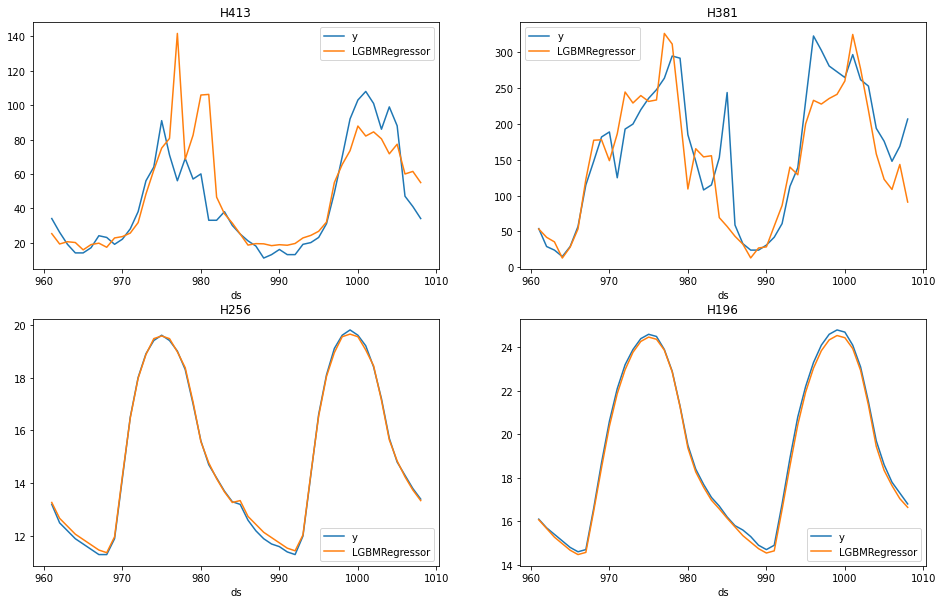

In [ ]:
results = valid.merge(predictions, on=['unique_id', 'ds']).set_index('unique_id')
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
for uid, axi in zip(sample_ids, ax.flat):
    results.loc[uid].set_index('ds').plot(ax=axi, title=uid)

In [ ]:
#| hide
# test new_data argument
test_eq(
    fcst.predict(horizon, new_data=train),
    predictions
)

MLForecast allows you to use a pretrained model to generate forecasts for a new dataset. Simply provide a pandas dataframe containing the new observations as the value for the `new_data` argument when calling the `predict` method. The dataframe should have the same structure as the one used to fit the model, including any features and time series data. The function will then use the pretrained model to generate forecasts for the new observations. This allows you to easily apply a pretrained model to a new dataset and generate forecasts without the need to retrain the model.

<AxesSubplot:title={'center':'ERCOT forecasts trained on M4-Hourly dataset'}, xlabel='ds'>

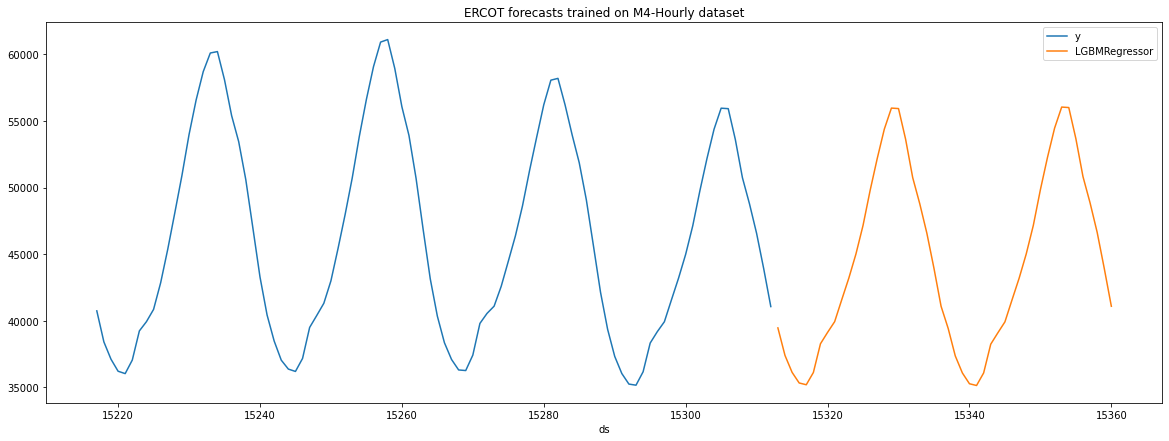

In [ ]:
ercot_df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/ERCOT-clean.csv')
# we have to convert the ds column to integers
# since MLForecast was trained with that structure
ercot_df['ds'] = np.arange(1, len(ercot_df) + 1)
# use the `new_data` argument to pass the ercot dataset 
ercot_fcsts = fcst.predict(horizon, new_data=ercot_df)
fig, ax = plt.subplots()
ercot_df.tail(48 * 2).plot(x='ds', y='y', figsize=(20, 7), ax=ax)
ercot_fcsts.plot(x='ds', y='LGBMRegressor', ax=ax, title='ERCOT forecasts trained on M4-Hourly dataset')

If you want to take a look at the data that will be used to train the models you can call `Forecast.preprocess`.

In [ ]:
show_doc(MLForecast.preprocess)

---

### MLForecast.preprocess

>      MLForecast.preprocess (data:pandas.core.frame.DataFrame, id_col:str,
>                             time_col:str, target_col:str,
>                             static_features:Optional[List[str]]=None,
>                             dropna:bool=True, keep_last_n:Optional[int]=None,
>                             max_horizon:Optional[int]=None,
>                             return_X_y:bool=False)

Add the features to `data`.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| max_horizon | typing.Optional[int] | None |  |
| return_X_y | bool | False |  |
| **Returns** | **typing.Union[pandas.core.frame.DataFrame, typing.Tuple[pandas.core.frame.DataFrame, typing.Union[pandas.core.series.Series, pandas.core.frame.DataFrame]]]** |  | **`data` plus added features and target(s).** |

In [ ]:
prep_df = fcst.preprocess(train, id_col='unique_id', time_col='ds', target_col='y')
prep_df

,unique_id,ds,y,lag24,lag48,lag72,lag96,lag120,lag144,lag168,ewm_mean_lag48_alpha0.3
86988,H196,193,0.1,0.0,0.0,0.0,0.3,0.1,0.1,0.3,0.002810
86989,H196,194,0.1,-0.1,0.1,0.0,0.3,0.1,0.1,0.3,0.031967
86990,H196,195,0.1,-0.1,0.1,0.0,0.3,0.1,0.2,0.1,0.052377
86991,H196,196,0.1,0.0,0.0,0.0,0.3,0.2,0.1,0.2,0.036664
86992,H196,197,0.0,0.0,0.0,0.1,0.2,0.2,0.1,0.2,0.025665
...,...,...,...,...,...,...,...,...,...,...,...
325187,H413,956,0.0,10.0,1.0,6.0,-53.0,44.0,-21.0,21.0,7.963225
325188,H413,957,9.0,10.0,10.0,-7.0,-46.0,27.0,-19.0,24.0,8.574257
325189,H413,958,16.0,8.0,5.0,-9.0,-36.0,32.0,-13.0,8.0,7.501980
325190,H413,959,-3.0,17.0,-7.0,2.0,-31.0,22.0,5.0,-2.0,3.151386


If we do this we then have to call `Forecast.fit_models`, since this only stores the series information.

In [ ]:
show_doc(MLForecast.fit_models)

---

### MLForecast.fit_models

>      MLForecast.fit_models (X:pandas.core.frame.DataFrame, y:Union[numpy.ndarr
>                             ay,pandas.core.series.Series,pandas.core.frame.Dat
>                             aFrame])

Manually train models. Use this if you called `Forecast.preprocess` beforehand.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| X | DataFrame | Features. |
| y | typing.Union[numpy.ndarray, pandas.core.series.Series, pandas.core.frame.DataFrame] | Target. |
| **Returns** | **MLForecast** | **Forecast object with trained models.** |

In [ ]:
X, y = prep_df.drop(columns=['unique_id', 'ds', 'y']), prep_df['y']
fcst.fit_models(X, y)

MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'ewm_mean_lag48_alpha0.3'], date_features=[], num_threads=1)

In [ ]:
predictions2 = fcst.predict(horizon)
pd.testing.assert_frame_equal(predictions, predictions2)

### Multi-output model

By default mlforecast uses the recursive strategy, i.e. a model is trained to predict the next value and if we're predicting several values we do it one at a time and then use the model's predictions as the new target, recompute the features and predict the next step.

There's another approach where if we want to predict 10 steps ahead we train 10 different models, where each model is trained to predict the value at each specific step, i.e. one model predicts the next value, another one predicts the value two steps ahead and so on. This can be very time consuming but can also provide better results. If you want to use this approach you can specify `max_horizon` in `MLForecast.fit`, which will train that many models and each model will predict its corresponding horizon when you call `MLForecast.predict`.

In [ ]:
def avg_mape(df):
    full = df.merge(valid)
    return abs(full['LGBMRegressor'] - full['y']).div(full['y']).groupby(full['unique_id']).mean()

In [ ]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(random_state=0),
    differences=[24],
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        1: [(rolling_mean, 24)],
        24: [(rolling_mean, 24)],
        48: [(ewm_mean, 0.3)],
    },
    num_threads=1,
)
max_horizon = 24
# the following will train 24 models, one for each horizon
individual_fcst = fcst.fit(train, id_col='unique_id', time_col='ds', target_col='y', max_horizon=max_horizon)
individual_preds = individual_fcst.predict(max_horizon)
avg_mape_individual = avg_mape(individual_preds).rename('individual')
# the following will train a single model and use the recursive strategy
recursive_fcst = fcst.fit(train, id_col='unique_id', time_col='ds', target_col='y')
recursive_preds = recursive_fcst.predict(max_horizon)
avg_mape_recursive = avg_mape(recursive_preds).rename('recursive')
# results
print('Average MAPE per method and serie')
avg_mape_individual.to_frame().join(avg_mape_recursive).applymap('{:.1%}'.format)

Average MAPE per method and serie


,individual,recursive
unique_id,,
H196,0.5%,0.6%
H256,0.7%,0.6%
H381,48.9%,20.3%
H413,26.9%,35.1%


### Cross validation

If we would like to know how good our forecast will be for a specific model and set of features then we can perform cross validation. What cross validation does is take our data and split it in two parts, where the first part is used for training and the second one for validation. Since the data is time dependant we usually take the last *x* observations from our data as the validation set.

This process is implemented in `Forecast.cross_validation`, which takes our data and performs the process described above for `n_windows` times where each window has `window_size` validation samples in it. For example, if we have 100 samples and we want to perform 2 backtests each of size 14, the splits will be as follows:

1. Train: 1 to 72. Validation: 73 to 86.
2. Train: 1 to 86. Validation: 87 to 100.

You can control the size between each cross validation window using the `step_size` argument. For example, if we have 100 samples and we want to perform 2 backtests each of size 14 and move one step ahead in each fold (`step_size=1`), the splits will be as follows:

1. Train: 1 to 85. Validation: 86 to 99.
2. Train: 1 to 86. Validation: 87 to 100.

In [ ]:
show_doc(MLForecast.cross_validation)

---

### MLForecast.cross_validation

>      MLForecast.cross_validation (data:pandas.core.frame.DataFrame,
>                                   n_windows:int, window_size:int, id_col:str,
>                                   time_col:str, target_col:str,
>                                   step_size:Optional[int]=None,
>                                   static_features:Optional[List[str]]=None,
>                                   dropna:bool=True,
>                                   keep_last_n:Optional[int]=None, dynamic_dfs:
>                                   Optional[List[pandas.core.frame.DataFrame]]=
>                                   None, before_predict_callback:Optional[Calla
>                                   ble]=None, after_predict_callback:Optional[C
>                                   allable]=None)

Perform time series cross validation.
Creates `n_windows` splits where each window has `window_size` test periods, 
trains the models, computes the predictions and merges the actuals.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| data | DataFrame |  | Series data in long format. |
| n_windows | int |  | Number of windows to evaluate. |
| window_size | int |  | Number of test periods in each window. |
| id_col | str |  | Column that identifies each serie. If 'index' then the index is used. |
| time_col | str |  | Column that identifies each timestep, its values can be timestamps or integers. |
| target_col | str |  | Column that contains the target. |
| step_size | typing.Optional[int] | None | Step size between each cross validation window. If None it will be equal to `window_size`. |
| static_features | typing.Optional[typing.List[str]] | None | Names of the features that are static and will be repeated when forecasting. |
| dropna | bool | True | Drop rows with missing values produced by the transformations. |
| keep_last_n | typing.Optional[int] | None | Keep only these many records from each serie for the forecasting step. Can save time and memory if your features allow it. |
| dynamic_dfs | typing.Optional[typing.List[pandas.core.frame.DataFrame]] | None | Future values of the dynamic features, e.g. prices. |
| before_predict_callback | typing.Optional[typing.Callable] | None | Function to call on the features before computing the predictions.<br>    This function will take the input dataframe that will be passed to the model for predicting and should return a dataframe with the same structure.<br>    The series identifier is on the index. |
| after_predict_callback | typing.Optional[typing.Callable] | None | Function to call on the predictions before updating the targets.<br>    This function will take a pandas Series with the predictions and should return another one with the same structure.<br>    The series identifier is on the index.            |
| **Returns** | **pandas DataFrame** |  | **Predictions for each window with the series id, timestamp, last train date, target value and predictions from each model.** |

In [ ]:
cv_results = fcst.cross_validation(
    train,
    n_windows=4,
    window_size=horizon,
    step_size=horizon,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
)
cv_results

,unique_id,ds,cutoff,y,LGBMRegressor
0,H196,769,768,15.2,15.167163
1,H196,770,768,14.8,14.767163
2,H196,771,768,14.4,14.467163
3,H196,772,768,14.1,14.167163
4,H196,773,768,13.8,13.867163
...,...,...,...,...,...
763,H413,956,912,59.0,64.284167
764,H413,957,912,58.0,64.830429
765,H413,958,912,53.0,40.726851
766,H413,959,912,38.0,42.739657


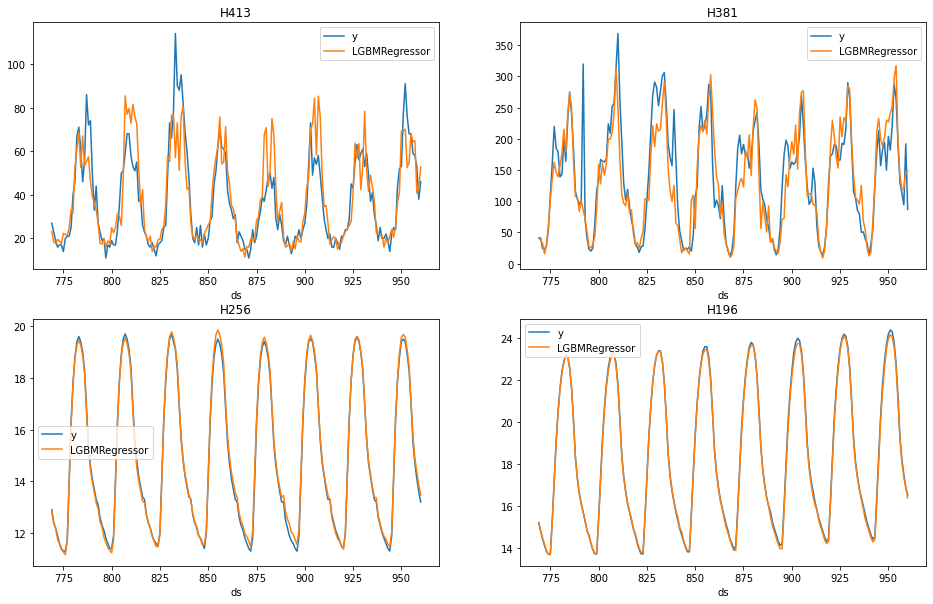

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for uid, axi in zip(sample_ids, ax.flat):
    subset = cv_results[cv_results['unique_id'].eq(uid)].drop(columns=['unique_id', 'cutoff'])
    subset.set_index('ds').plot(ax=axi, title=uid)

### Create MLForecast from LightGBMCV

Once you've found a set of features and parameters that work for your problem you can build a forecast object from it using `MLForecast.from_cv`, which takes the trained `LightGBMCV` object and builds an `MLForecast` object that will use the same features and parameters. Then you can call fit and predict as you normally would.

In [ ]:
cv = LightGBMCV(
    freq=1,
    differences=[24],
    lags=[24 * (i+1) for i in range(7)],
    lag_transforms={
        48: [(ewm_mean, 0.3)],
    },
    num_threads=1,
)
hist = cv.fit(
    train,
    n_windows=2,
    window_size=horizon,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
    params={'verbosity': -1},
)

[LightGBM] [Info] Start training from score 0.084340
[10] mape: 0.118569
[20] mape: 0.111506
[30] mape: 0.107314
[40] mape: 0.106089
[50] mape: 0.106630
Early stopping at round 50
Using best iteration: 40


In [ ]:
fcst = MLForecast.from_cv(cv)
assert cv.best_iteration_ == fcst.models['LGBMRegressor'].n_estimators

In [ ]:
fcst.fit(
    train,
    id_col='unique_id',
    time_col='ds',
    target_col='y',
)
fcst.predict(horizon)

,unique_id,ds,LGBMRegressor
0,H196,961,16.111079
1,H196,962,15.711079
2,H196,963,15.311079
3,H196,964,15.011079
4,H196,965,14.711079
...,...,...,...
187,H413,1004,92.722032
188,H413,1005,69.153603
189,H413,1006,68.811675
190,H413,1007,53.693346


### Dynamic features

We're going to use a synthetic dataset from this point onwards to demonstrate some other functionalities regarding external regressors.

In [ ]:
series = generate_daily_series(100, equal_ends=True, n_static_features=2, static_as_categorical=False)
series

,ds,y,static_0,static_1
unique_id,,,,
id_00,2000-10-05,3.981198,79,45
id_00,2000-10-06,10.327401,79,45
id_00,2000-10-07,17.657474,79,45
id_00,2000-10-08,25.898790,79,45
id_00,2000-10-09,34.494040,79,45
...,...,...,...,...
id_99,2001-05-10,45.340051,69,35
id_99,2001-05-11,3.022948,69,35
id_99,2001-05-12,10.131371,69,35


As we saw in the previous example, the required columns are the series identifier, time and target. Whatever extra columns you have, like `static_0` and `static_1` here are considered to be static and are replicated when constructing the features for the next timestamp. You can disable this by passing `static_features` to `MLForecast.preprocess` or `MLForecast.fit` , which will only keep the columns you define there as static. Keep in mind that they will still be used for training, so you'll have to provide them to `MLForecast.predict` through the `dynamic_dfs` argument.

By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features like prices or a calendar with holidays you can pass them as a list to the `dynamic_dfs` argument of `MLForecast.predict`, which will call `pd.DataFrame.merge` on each of them in order.

Here's an example:

Suppose that we have a `product_id` column and we have a catalog for prices based on that `product_id` and the date.

In [ ]:
dynamic_series = series.rename(columns={'static_1': 'product_id'})
prices_catalog = generate_prices_for_series(dynamic_series)
prices_catalog

,ds,product_id,price
0,2000-06-09,1,0.548814
1,2000-06-10,1,0.715189
2,2000-06-11,1,0.602763
3,2000-06-12,1,0.544883
4,2000-06-13,1,0.423655
...,...,...,...
20180,2001-05-17,99,0.223520
20181,2001-05-18,99,0.446104
20182,2001-05-19,99,0.044783
20183,2001-05-20,99,0.483216


And you have already merged these prices into your series dataframe.

In [ ]:
series_with_prices = dynamic_series.reset_index().merge(prices_catalog, how='left')
series_with_prices.set_index('unique_id', inplace=True)
series_with_prices

,ds,y,static_0,product_id,price
unique_id,,,,,
id_00,2000-10-05,3.981198,79,45,0.570826
id_00,2000-10-06,10.327401,79,45,0.260562
id_00,2000-10-07,17.657474,79,45,0.274048
id_00,2000-10-08,25.898790,79,45,0.433878
id_00,2000-10-09,34.494040,79,45,0.653738
...,...,...,...,...,...
id_99,2001-05-10,45.340051,69,35,0.792152
id_99,2001-05-11,3.022948,69,35,0.782687
id_99,2001-05-12,10.131371,69,35,0.019463


This dataframe will be passed to `MLForecast.fit` (or `MLForecast.preprocess`), however since the price is dynamic we have to tell that method that only `static_0` and `product_id` are static and we'll have to update `price` in every timestep, which basically involves merging the updated features with the prices catalog.

In [ ]:
def even_day(dates):
    return dates.day % 2 == 0

models = [
    lgb.LGBMRegressor(n_jobs=1, random_state=0),
    xgb.XGBRegressor(n_jobs=1, random_state=0),
]
fcst = MLForecast(
    models,
    freq='D',
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    date_features=['dayofweek', 'month', even_day],
    num_threads=2,
)
fcst.fit(
    series_with_prices,
    id_col='index',
    time_col='ds',
    target_col='y',
    static_features=['static_0', 'product_id'],
)

MLForecast(models=[LGBMRegressor, XGBRegressor], freq=<Day>, lag_features=['lag7', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size14'], date_features=['dayofweek', 'month', <function even_day>], num_threads=2)

The features used for training are stored in `Forecast.ts.features_order_`, as you can see `price` was used for training.

In [ ]:
fcst.ts.features_order_

['static_0',
 'product_id',
 'price',
 'lag7',
 'expanding_mean_lag1',
 'rolling_mean_lag7_window_size14',
 'dayofweek',
 'month',
 'even_day']

So in order to update the price in each timestep we just call `Forecast.predict` with our forecast horizon and pass the prices catalog as a dynamic dataframe.

In [ ]:
preds = fcst.predict(7, dynamic_dfs=[prices_catalog])
preds

,ds,LGBMRegressor,XGBRegressor
unique_id,,,
id_00,2001-05-15,42.184358,43.174004
id_00,2001-05-16,50.186606,50.842575
id_00,2001-05-17,1.940786,1.911936
id_00,2001-05-18,10.432289,9.788165
id_00,2001-05-19,18.701071,18.377850
...,...,...,...
id_99,2001-05-17,44.311743,43.611797
id_99,2001-05-18,1.909511,1.922798
id_99,2001-05-19,9.067718,8.772107


In [ ]:
#|hide
preds2 = fcst.predict(7, dynamic_dfs=[prices_catalog])
preds3 = fcst.predict(7, new_data=series_with_prices, dynamic_dfs=[prices_catalog])

pd.testing.assert_frame_equal(preds, preds2)
pd.testing.assert_frame_equal(preds, preds3)

In [ ]:
#|hide
non_std_series = series.copy()
non_std_series['ds'] = non_std_series.groupby('unique_id').cumcount()
non_std_series = non_std_series.reset_index().rename(columns={'unique_id': 'some_id', 'ds': 'time', 'y': 'value'})
flow_params = dict(
    models=models,
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    num_threads=2,
)
fcst = MLForecast(**flow_params)
non_std_preds = fcst.fit(non_std_series, id_col='some_id', time_col='time', target_col='value').predict(7)
non_std_preds = non_std_preds.rename(columns={'some_id': 'unique_id'}).set_index('unique_id')
fcst = MLForecast(freq='D', **flow_params)
preds = fcst.fit(series, id_col='index', time_col='ds', target_col='y').predict(7)
pd.testing.assert_frame_equal(preds.drop(columns='ds'), non_std_preds.drop(columns='time'))

### Custom predictions
As you may have noticed `MLForecast.predict` can take a `before_predict_callback` and `after_predict_callback`. By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features you can pass them as a list to `MLForecast.predict` in the `dynamic_dfs` argument. However, if you want to do something to the input before predicting or do something to the output before it gets used to update the target (and thus the next features that rely on lags), you can pass a function to run at any of these times. 

Suppose that we want to look at our inputs and scale our predictions so that our series are updated with these scaled values. We can achieve that with the following:

In [ ]:
from IPython.display import display

def inspect_input(new_x):
    """Displays the first row of our input to inspect it"""
    print('Inputs:')
    display(new_x.head(1))
    return new_x

def increase_predictions(predictions):
    """Prints the last prediction and increases all of them by 10%."""
    print(f'Prediction:\n{predictions.tail(1)}\n')
    return 1.1 * predictions

And now we just pass these functions to `MLForecast.predict`.

In [ ]:
fcst = MLForecast(lgb.LGBMRegressor(), freq='D', lags=[7])
fcst.fit(series, id_col='index', time_col='ds', target_col='y')

preds = fcst.predict(2, before_predict_callback=inspect_input, after_predict_callback=increase_predictions)
preds

Inputs:


,static_0,static_1,lag7
unique_id,,,
id_00,79,45,43.150169


Prediction:
unique_id
id_99    29.638271
dtype: float64

Inputs:


,static_0,static_1,lag7
unique_id,,,
id_00,79,45,50.425902


Prediction:
unique_id
id_99    37.138933
dtype: float64



,ds,LGBMRegressor
unique_id,,
id_00,2001-05-15,46.298462
id_00,2001-05-16,54.772835
id_01,2001-05-15,12.808338
id_01,2001-05-16,16.426544
id_02,2001-05-15,16.339826
...,...,...
id_97,2001-05-16,38.865211
id_98,2001-05-15,8.268328
id_98,2001-05-16,10.476819


In [ ]:
#|hide
fcst.ts._predict_setup()

for attr in ('head', 'tail'):
    new_x = fcst.ts._update_features().drop(columns='ds')
    original_preds = fcst.models_['LGBMRegressor'].predict(new_x)
    
    expected = 1.1 * original_preds
    actual = getattr(preds.groupby('unique_id')[models[0].__class__.__name__], attr)(1).values
    np.testing.assert_equal(expected, actual)
    
    fcst.ts._update_y(actual)

In [ ]:
#|hide
n_windows = 2
window_size = 14
fcst = MLForecast(lgb.LGBMRegressor(), freq='D', lags=[7, 14])
backtest_results = fcst.cross_validation(
    non_std_series,
    n_windows,
    window_size,
    id_col='some_id',
    time_col='time',
    target_col='value',
    static_features=['static_0', 'static_1'],
)
renamer = {'some_id': 'unique_id', 'time': 'ds', 'value': 'y'}
backtest_results = backtest_results.rename(columns=renamer).set_index('unique_id')
renamed = non_std_series.rename(columns=renamer).set_index('unique_id')
manual_results = []
for cutoff, train, valid in backtest_splits(renamed, n_windows, window_size, 1):
    fcst.fit(
        train,
        id_col='index',
        time_col='ds',
        target_col='y',
        static_features=['static_0', 'static_1'],
    )
    pred = fcst.predict(window_size)
    res = valid[['ds', 'y']].copy()
    res['cutoff'] = cutoff
    res = res[['ds', 'cutoff', 'y']].copy()
    manual_results.append(res.merge(pred, on=['unique_id', 'ds'], how='left'))
manual_results = pd.concat(manual_results)
pd.testing.assert_frame_equal(backtest_results, manual_results)